In [65]:
import os

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj as proj
from datetime import datetime
import pandas as pd
from netCDF4 import Dataset  # pylint:disable=no-name-in-module
from shapely.geometry import Point

sf_type = 1
marker_size = 1

# Antarctica

In [66]:
nc = Dataset(
    os.path.join(
        os.environ["HOME"],
        "Documents",
        "eocis",
        "landice_dash_test",
        "data_files",
        "EOCIS-GIS-L3C-SEC-MULTIMISSION-5KM-5YEAR-MEANS-201001-201501-fv1.nc",
    )
)

In [67]:
for k, v in nc.variables.items():
    print(k, "\n", v)
    print()

sec 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec(time_period, ny, nx)
    long_name: surface elevation change
    units: m/yr
    source: multi-mission radar altimetry
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

sec_uncertainty 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec_uncertainty(time_period, ny, nx)
    long_name: uncertainty in surface elevation change
    units: m/yr
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

x 
 <class 'netCDF4._netCDF4.Variable'>
float32 x(nx)
    long_name: Cartesian x-coordinate - easting, of centre of each grid cell
    units: meters
    standard_name: projection_x_coordinate
    min_val: -997500.0
    binsize: 5000.0
unlimited dimensions: 
current shape = (420,)
filling on, default _FillValue of 9.969209968386869e+36 used

y 
 <class 'netC

In [68]:
nc["basin_id"][:].data.shape

(620, 420)

In [69]:
x_values: np.ndarray = nc["x"][:].data
y_values: np.ndarray = nc["y"][:].data
lat: np.ndarray = nc["lat"][:].data
lon: np.ndarray = nc["lon"][:].data
surf_type: np.ndarray = nc["surface_type"][:].data
sec: np.ndarray = np.squeeze(nc["sec"][:].data)

x_coords, y_coords = np.meshgrid(x_values, y_values, indexing="xy")

print(x_values.shape, y_values.shape)
print(x_coords.shape, y_coords.shape, sec.shape, surf_type.shape)

(420,) (620,)
(620, 420) (620, 420) (620, 420) (620, 420)


In [70]:
coords_arr = [Point(x, y) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
sec_arr = sec.flatten()
surf_type_arr = surf_type.flatten()

print(len(coords_arr), sec_arr.shape, surf_type_arr.shape)

260400 (260400,) (260400,)


In [71]:
my_data = gpd.GeoDataFrame(
    data={
        "SEC": sec_arr,
        "surface type": surf_type_arr,
        "geometry": coords_arr,
    },
    crs="epsg:3031",
)
my_data.head()

,SEC,surface type,geometry
0,NaN,0,POINT (-997500.000 -3497500.000)
1,NaN,0,POINT (-992500.000 -3497500.000)
2,NaN,0,POINT (-987500.000 -3497500.000)
3,NaN,0,POINT (-982500.000 -3497500.000)
4,NaN,0,POINT (-977500.000 -3497500.000)


In [72]:
sum(my_data["SEC"].isna())

208238

In [73]:
ais_basins = gpd.read_file("aux_files/IMBIE_AIS_Basins/ANT_Basins_IMBIE2_v1.6.shp")
ais_basins = (
    ais_basins.reset_index().rename(columns={"index": "basin_id"}).to_crs("epsg:4326")
)
ais_basins["basin_id"] = (ais_basins["basin_id"] + 1).astype(str)
ais_basins.head()

,basin_id,Regions,Subregion,geometry
0,1,Islands,None,"MULTIPOLYGON (((108.91949 -66.91047, 108.91933..."
1,2,West,H-Hp,"POLYGON ((-90.24588 -74.02074, -90.53000 -73.9..."
2,3,West,F-G,"POLYGON ((-144.36800 -75.62323, -144.36771 -75..."
3,4,East,E-Ep,"POLYGON ((-151.52291 -85.37243, -151.30170 -85..."
4,5,East,D-Dp,"POLYGON ((144.62895 -67.18320, 144.62074 -67.1..."


In [74]:
# crs_3031 = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
# transformed = my_data.to_crs(crs_3031)

# fig, ax = plt.subplots(
#     figsize=(8, 6), facecolor="white", subplot_kw=dict(projection=crs_3031)
# )  # Create our plot

# transformed[transformed["SEC"].notna()].plot(
#     column="SEC",
#     ax=ax,
#     legend=True,
#     vmax=2,
#     vmin=-2,
#     marker="s",
#     markersize=marker_size,
#     cmap="bwr_r",
# )

# ais_basins.plot(color="none", edgecolor="black", ax=ax, alpha=0.5, lw=0.7)

# # ax.coastlines(resolution="50m", color="black")  # Add coastlines
# gl = ax.gridlines(draw_labels=True, color="black", alpha=0.25)
# gl.ylabel_style = {
#     "color": "black",
#     "alpha": 0.5,
# }
# ax.set_xlim(-2.8e6, 2.8e6)
# ax.set_ylim(-2.8e6, 2.8e6)

# fig.show()

In [75]:
timedata_ais = pd.read_csv(
    "/home/jgnq4/Documents/eocis/landice_dash_test/processed_files/time_series_data_AIS.csv"
).sort_values("code")

max_v_ais = np.round(timedata_ais["SEC"].abs().max(axis=None) + 0.05, 1)
timedata_ais = timedata_ais.reset_index(drop=True).reset_index()
timedata_ais["basin"] = timedata_ais["basin"].astype(str)
timedata_ais = pd.merge(
    timedata_ais,
    ais_basins[["basin_id", "Subregion"]],
    how="outer",
    left_on="basin",
    right_on="basin_id",
).drop(columns="basin_id")
timedata_ais["midpoint"] = datetime(
    year=timedata_ais["midpoint"] // 1
).timestamp() + timedata_ais["midpoint"] % 1 * (365 * 24 * 60 * 60)
timedata_ais.loc[timedata_ais["basin"] == "all", "Subregion"] = "All"
timedata_ais.loc[timedata_ais["basin"] == "0", "Subregion"] = "Outside Basins"
timedata_ais

TypeError: 'Series' object cannot be interpreted as an integer

In [ ]:
test_data = timedata_ais[timedata_ais["basin"] == "1"]
test_data

,index,code,period,midpoint,basin,SEC,Subregion
327,18.0,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.186259,None
328,33.0,199108-199608,1991/08 - 1996/08,1994.160767,1,-0.186594,None
329,51.0,199109-199609,1991/09 - 1996/09,1994.245605,1,-0.186594,None
330,72.0,199110-199610,1991/10 - 1996/10,1994.327637,1,-0.186594,None
331,97.0,199111-199611,1991/11 - 1996/11,1994.412476,1,-0.186594,None
...,...,...,...,...,...,...,...
649,6452.0,201805-202305,2018/05 - 2023/05,2020.908203,1,-0.001716,None
650,6477.0,201806-202306,2018/06 - 2023/06,2020.993164,1,-0.001716,None
651,6497.0,201807-202307,2018/07 - 2023/07,2021.075317,1,-0.001716,None
652,6517.0,201808-202308,2018/08 - 2023/08,2021.160278,1,-0.001716,None


In [ ]:
len(test_data)

327

In [ ]:
dh_data = [np.trapz(test_data["SEC"].to_numpy()[:i]) for i in range(1, len(test_data))]
dh_data

[0.0,
 -0.1864263787865638,
 -0.3730203583836554,
 -0.559614337980747,
 -0.7462083175778386,
 -0.9218465164303775,
 -1.086528934538364,
 -1.2512113526463504,
 -1.4158937707543369,
 -1.5739542394876476,
 -1.727524101734161,
 -1.8832253068685527,
 -2.0389265120029445,
 -2.1946277171373363,
 -2.3326432369649406,
 -2.4529730714857574,
 -2.5733029060065737,
 -2.6936327405273905,
 -2.8139625750482073,
 -2.92110826447606,
 -3.0150698088109484,
 -3.109031353145837,
 -3.2029928974807254,
 -3.2645945800468317,
 -3.293836400844156,
 -3.32307822164148,
 -3.352320042438804,
 -3.3815618632361284,
 -3.3790561314672223,
 -3.344802847132086,
 -3.3105495627969495,
 -3.276296278461813,
 -3.242042994126676,
 -3.199942402541636,
 -3.1499945037066923,
 -3.1000466048717485,
 -3.0500987060368048,
 -2.994863899424671,
 -2.9343421850353466,
 -2.8738204706460224,
 -2.8132987562566987,
 -2.7527770418673745,
 -2.6932149678468695,
 -2.634612534195184,
 -2.576010100543498,
 -2.5174076668918124,
 -2.4469797741621724,

In [ ]:
import altair as alt
import vl_convert as vlc
import json
from IPython.display import Image

alt.data_transformers.enable("vegafusion")

click_basin_ais = alt.selection_point(fields=["Subregion"])

map_ais = (
    alt.Chart(
        ais_basins,
    )
    .mark_geoshape()
    .encode(
        color=alt.Color("Subregion:N").legend(orient="right"),
        opacity=alt.condition(click_basin_ais, alt.value(1), alt.value(0.2)),
        tooltip=["basin_id:N", "Subregion:N", "Regions:N"],
    )
    .project(type="stereographic", center=[-90, -180])
    .properties(width=300, height=300)
)

jchart1 = alt.JupyterChart(map_ais.add_params(click_basin_ais))
jchart1

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_1_store'}…

In [ ]:
# nearest = alt.selection_point(nearest=True, on="mouseover", fields=["index"], empty=False)

line_ais = (
    alt.Chart(timedata_ais, title="Mean SEC per Basin")
    .mark_line()
    .encode(
        alt.X("midpoint:Q", axis=alt.Axis(labels=False), title="Time Period"),
        alt.Y(
            "SEC:Q",
            scale=alt.Scale(domain=(-max_v_ais, max_v_ais)),
            title="Mean elevation change (m/year)",
        ),
        opacity=alt.condition(click_basin_ais, alt.value(1), alt.value(0.05)),
        color=alt.Color("Subregion:N"),
        tooltip=["SEC", "period", "Subregion"],
    )
    .properties(width=900, height=300)
)

# # Draw a rule at the location of the selection
# rules = base.mark_rule(color="gray").encode(
#     x="index:Q",
#     opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
#     tooltip=[
#         alt.Tooltip("period", type="nominal", title="Time period"),
#     ],
# )

# points = line.mark_circle().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))

zero = pd.DataFrame([{"zero": 0.0}])
zero_rule = (
    alt.Chart(zero)
    .mark_rule(color="black", strokeDash=[1])
    .encode(y="zero:Q", size=alt.value(1))
)

line_chart_ais = line_ais + zero_rule

jchart2 = alt.JupyterChart(line_chart_ais.add_params(click_basin_ais))
jchart2

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_1_store'}…

In [ ]:
chart = (line_chart_ais | map_ais).add_params(click_basin_ais)


jchart = alt.JupyterChart(chart)
jchart

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_1_store'}…

# Greenland

In [ ]:
nc = Dataset(
    os.path.join(
        os.environ["HOME"],
        "Documents",
        "eocis",
        "landice_dash_test",
        "data_files",
        "EOCIS-GIS-L3C-SEC-MULTIMISSION-5KM-5YEAR-MEANS-201001-201501-fv1.nc",
    )
)

In [ ]:
for k, v in nc.variables.items():
    print(k, "\n", v)
    print()

sec 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec(time_period, ny, nx)
    long_name: surface elevation change
    units: m/yr
    source: multi-mission radar altimetry
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

sec_uncertainty 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec_uncertainty(time_period, ny, nx)
    long_name: uncertainty in surface elevation change
    units: m/yr
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

x 
 <class 'netCDF4._netCDF4.Variable'>
float32 x(nx)
    long_name: Cartesian x-coordinate - easting, of centre of each grid cell
    units: meters
    standard_name: projection_x_coordinate
    min_val: -997500.0
    binsize: 5000.0
unlimited dimensions: 
current shape = (420,)
filling on, default _FillValue of 9.969209968386869e+36 used

y 
 <class 'netC

In [ ]:
x_values: np.ndarray = nc["x"][:].data
y_values: np.ndarray = nc["y"][:].data
lat: np.ndarray = nc["lat"][:].data
lon: np.ndarray = nc["lon"][:].data
surf_type: np.ndarray = nc["surface_type"][:].data
sec: np.ndarray = np.squeeze(nc["sec"][:].data)

x_coords, y_coords = np.meshgrid(x_values, y_values, indexing="xy")

print(x_values.shape, y_values.shape)
print(x_coords.shape, y_coords.shape, sec.shape, surf_type.shape)
print("X:", np.min(x_values), np.max(x_values))
print("Y:", np.min(y_values), np.max(y_values))

(420,) (620,)
(620, 420) (620, 420) (620, 420) (620, 420)
X: -997500.0 1097500.0
Y: -3497500.0 -402500.0


In [ ]:
coords_arr = [Point(x, y) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
sec_arr = sec.flatten()
surf_type_arr = surf_type.flatten()

print(len(coords_arr), sec_arr.shape, surf_type_arr.shape)

260400 (260400,) (260400,)


In [ ]:
my_data = gpd.GeoDataFrame(
    data={
        "SEC": sec_arr,
        "surface type": surf_type_arr,
        "geometry": coords_arr,
    },
    crs="epsg:3413",
)
my_data.head()

,SEC,surface type,geometry
0,NaN,0,POINT (-997500.000 -3497500.000)
1,NaN,0,POINT (-992500.000 -3497500.000)
2,NaN,0,POINT (-987500.000 -3497500.000)
3,NaN,0,POINT (-982500.000 -3497500.000)
4,NaN,0,POINT (-977500.000 -3497500.000)


In [ ]:
crs_new = ccrs.NorthPolarStereo(central_longitude=-40)
gis_basins = gpd.read_file(
    "aux_files/IMBIE_GIS_Basins/Greenland_Basins_PS_v1.4.2.shp"
).to_crs("EPSG:4326")
gis_basins = gis_basins.reset_index().rename(
    columns={"index": "basin_id", "SUBREGION1": "Subregion"}
)
gis_basins["basin_id"] = (gis_basins["basin_id"] + 1).astype(str)
gis_basins.head(10)

,basin_id,Subregion,NAME,GL_TYPE,geometry
0,1,CE,None,None,"POLYGON ((-32.84621 68.55410, -32.84621 68.554..."
1,2,CW,None,None,"POLYGON ((-51.20762 71.61893, -51.20951 71.618..."
2,3,NO,None,None,"POLYGON ((-71.46118 78.14071, -71.65543 78.133..."
3,4,NE,None,None,"POLYGON ((-22.65215 79.51328, -22.65259 79.511..."
4,5,NW,None,None,"POLYGON ((-52.26019 71.88370, -52.27234 71.886..."
5,6,SE,None,None,"POLYGON ((-39.14148 65.77665, -39.14072 65.779..."
6,7,SW,None,None,"POLYGON ((-50.24135 68.22278, -50.20214 68.234..."


/tmp/ipykernel_6587/3502128069.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


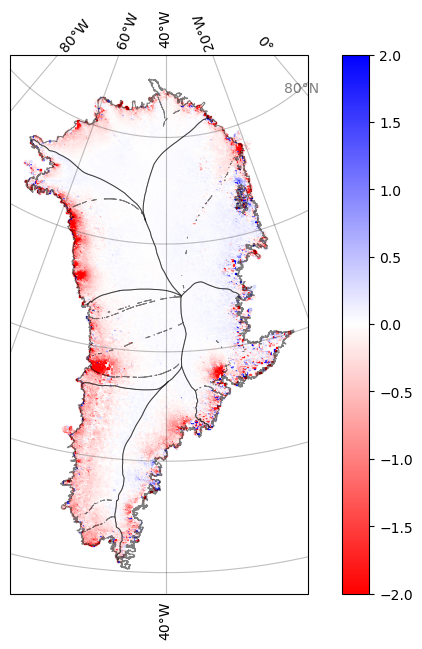

In [ ]:
crs_new = ccrs.NorthPolarStereo(central_longitude=-40)
transformed = my_data.to_crs(crs_new)

fig, ax = plt.subplots(
    figsize=(9, 7), facecolor="white", subplot_kw=dict(projection=crs_new)
)  # Create our plot

transformed[transformed["SEC"].notna()].plot(
    column="SEC",
    ax=ax,
    legend=True,
    vmax=2,
    vmin=-2,
    marker="s",
    markersize=marker_size,
    cmap="bwr_r",
)

gis_basins.to_crs(crs_new).plot(
    color="none", edgecolor="black", ax=ax, alpha=0.5, lw=0.7
)

gl = ax.gridlines(draw_labels=True, color="black", alpha=0.25)
gl.ylabel_style = {
    "color": "black",
    "alpha": 0.5,
}


fig.show()

In [ ]:
click_basin_gis = alt.selection_point(fields=["Subregion"], bind="legend")

map_gis = (
    alt.Chart(
        gis_basins.to_crs(epsg="4326"),
    )
    .mark_geoshape()
    .encode(
        color=alt.Color(
            "Subregion:N",
            sort=["All", "Outside basin", "NO", "NE", "NW", "CE", "CW", "SE", "SW"],
        ).legend(orient="right"),
        opacity=alt.condition(click_basin_gis, alt.value(1), alt.value(0.2)),
        tooltip=["basin_id:N", "Subregion:N"],
    )
    .project("stereographic", rotate=[0, 45, 20])
)

jchart4 = alt.JupyterChart(map_gis.add_params(click_basin_gis), debounce_wait=1000)
jchart4

JupyterChart(debounce_wait=1000.0, spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'n…

In [ ]:
timedata_gis = pd.read_csv(
    "/home/jgnq4/Documents/eocis/landice_dash_test/processed_files/time_series_data_GIS.csv"
).sort_values("code")

max_v_gis = np.round(timedata_gis["SEC"].abs().max(axis=None) + 0.05, 1)
timedata_gis = timedata_gis.reset_index(drop=True).reset_index()
timedata_gis["basin"] = timedata_gis["basin"].astype(str)
timedata_gis = pd.merge(
    timedata_gis,
    gis_basins[["basin_id", "Subregion"]],
    how="outer",
    left_on="basin",
    right_on="basin_id",
).drop(columns="basin_id")
timedata_gis.loc[timedata_gis["basin"] == "all", "Subregion"] = "All"
timedata_gis = timedata_gis.drop(np.where(timedata_gis["basin"] == "0")[0], axis=0)
# timedata_gis.loc[timedata_gis["basin"] == "0", "Subregion"] = "Outside"

timedata_gis

,index,code,period,midpoint,basin,SEC,Subregion
2133,6,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.007654,CE
2134,15,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.007654,CE
2135,24,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.007654,CE
2136,29,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.007654,CE
2137,38,199107-199607,1991/07 - 1996/07,1994.075928,1,-0.007654,CE
...,...,...,...,...,...,...,...
19192,19155,201809-202309,2018/09 - 2023/09,2021.245239,all,-0.098539,All
19193,19156,201809-202309,2018/09 - 2023/09,2021.245239,all,-0.098539,All
19194,19182,201809-202309,2018/09 - 2023/09,2021.245239,all,-0.098539,All
19195,19191,201809-202309,2018/09 - 2023/09,2021.245239,all,-0.098539,All


In [ ]:
max_v_gis

0.6

In [ ]:
timedata_gis[timedata_gis["basin"] == "7"]

,index,code,period,midpoint,basin,SEC,Subregion
14931,3,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
14932,12,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
14933,21,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
14934,35,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
14935,44,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
...,...,...,...,...,...,...,...
17059,19154,201809-202309,2018/09 - 2023/09,2021.245239,7,-0.129848,SW
17060,19157,201809-202309,2018/09 - 2023/09,2021.245239,7,-0.129848,SW
17061,19181,201809-202309,2018/09 - 2023/09,2021.245239,7,-0.129848,SW
17062,19190,201809-202309,2018/09 - 2023/09,2021.245239,7,-0.129848,SW


In [ ]:
line_gis = (
    alt.Chart(timedata_gis, title="Mean SEC per Basin")
    .mark_line()
    .encode(
        alt.X(
            "midpoint:Q",
            axis=alt.Axis(format="4d", tickMinStep=2),
            title="Time Period",
        ),
        alt.Y(
            "SEC:Q",
            scale=alt.Scale(domain=(-max_v_gis, max_v_gis)),
            title="Mean elevation change (m/year)",
        ),
        opacity=alt.condition(click_basin_gis, alt.value(1), alt.value(0.05)),
        color=alt.Color(
            "Subregion:N",
            sort=["All", "Outside basin", "NO", "NE", "NW", "CE", "CW", "SE", "SW"],
        ).legend(orient="right"),
        tooltip=["SEC", "period", "Subregion"],
    )
    .properties(width=900, height=300)
)

# # Draw a rule at the location of the selection
# rules = base.mark_rule(color="gray").encode(
#     x="index:Q",
#     opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
#     tooltip=[
#         alt.Tooltip("period", type="nominal", title="Time period"),
#     ],
# )

# points = line.mark_circle().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))

zero = pd.DataFrame([{"zero": 0.0}])
zero_rule = (
    alt.Chart(zero).mark_rule(color="black", strokeDash=[1]).encode(y="zero:Q", size=alt.value(1))
)

line_chart_gis = line_gis + zero_rule

jchart4 = alt.JupyterChart(line_chart_gis.add_params(click_basin_gis))
jchart4

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_2_store'}…

In [ ]:
chart = (line_chart_gis | map_gis).add_params(click_basin_gis)


jchart = alt.JupyterChart(chart)
jchart

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_2_store'}…